In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier 
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.datasets import load_iris
from sklearn.svm import SVC

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

# 07. 集成学习和随机森林
假设你去随机问很多人一个很复杂的问题，然后把它们的答案合并起来。通常情况下你会发现这个合并的答案比一个专家的答案要好。这就叫做`群体智慧`。同样的，如果你合并了一组分类器的预测(像分类或者回归)，你也会得到一个比单一分类器更好的预测结果。这一组分类器就叫做`集成`；因此，这个技术就叫做`集成学习`，一个集成学习算法就叫做`集成方法`。

例如，你可以训练一组决策树分类器，每一个都在一个随机的训练集上。为了去做预测，你必须得到所有单一树的预测值，然后通过投票(例如第六章的练习)来预测类别。例如一种决策树的集成就叫做`随机森林`，它除了简单之外也是现今存在的最强大的机器学习算法之一。

此外，象我们在第二章讨论的一样，我们会在一个项目快结束的时候使用集成算法，一旦你建立了一些好的分类器，就把他们合并为一个更好的分类器。事实上，在机器学习竞赛中获得胜利的算法经常会包含一些集成方法(例如著名的`Netflix Prize competition`)。

在本章中我们会讨论一些广受好评的集成方法，包括`bagging`、`boosting`、`stacking`和其它一些算法。我们也会讨论随机森林。

## 7.1 投票分类
假设你已经训练了一些分类器，每一个都有80%的准确率。你可能有了一个Logit回归、或一个SVM、或一个随机森林，或者一个KNN，或许还有更多(详见`图7-1`)：

<img src="images/07_01.png" style="width:500px;"/>

一个非常简单的创建一个更好的分类器的方法就是整合每一个分类器的预测然后经过投票去预测分类。这种分类器就叫做`硬投票分类器`(详见`图7-2`)：

<img src="images/07_02.png" style="width:500px;"/>

令人惊奇的是这种投票分类器得出的结果经常会比集成中最好的一个分类器结果更好。事实上，即使每一个分类器都是一个`弱学习器`(意味着它们也就比瞎猜好点)，集成后仍然是一个`强学习器`(高准确率)，只要有足够数量的弱学习者，并且他们足够多样化。

这怎么可能？接下来的分析将帮助你解决这个疑问。假设你有一个有偏差的硬币，他有51%的几率为正面，49%的几率为背面。如果你实验1000次，你会得到差不多510次正面，490次背面，因此大多数都是正面。如果你用数学计算，你会发现在实验1000次后，得到正面比反面多的结果的比例为75%。你实验的次数越多，得到上述结果的比例越大(例如你试验了10000次，总体比例可能性就会达到97%)。这是因为`大数定律` ：当你一直用硬币实验时，正面的比例会越来越接近51%。`图7-3`展示了始终有偏差的硬币实验。你可以看到当实验次数上升时，正面的概率接近于51%。最终所有10种实验都会收敛到51%，它们都大于50%。

<img src="images/07_03.png" style="width:600px;"/>

同样的，假设你创建了一个包含1000个分类器的集成模型，其中每个分类器的正确率只有51%(仅比瞎猜好一点点)。如果你用投票去预测类别，你可能得到75%的准确率！然而，这仅仅在所有的分类器都独立运行的很好、不会发生有相关性的错误的情况下才会这样，然而每一个分类器都在同一个数据集上训练，导致其很可能会发生这样的错误。他们可能会犯同一种错误，所以也会有很多票投给了错误类别导致集成的准确率下降。

> 如果使每一个分类器都独立自主的分类，那么集成模型会工作的很好。得到多样的分类器的方法之一就是用完全不同的算法，这会使它们会做出不同种类的错误，这会提高集成的正确率

接下来的代码创建和训练了在Scikit-Learn中的投票分类器。这个分类器由三个不同的分类器组成(训练集是第五章中的moons数据集)：

In [2]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(solver='lbfgs') 
rnd_clf = RandomForestClassifier(n_estimators=100) 
svm_clf = SVC(gamma='scale')

voting_clf = VotingClassifier( estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard') 
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test) 
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


你看！投票分类器比其他单独的分类器表现的都要好。

[todo]如果所有的分类器都能够预测类别的概率(例如他们有一个`predict_proba()`方法)，那么你就可以让Scikit-Learn以最高的类概率来预测这个类，平均在所有的分类器上。这种方式叫做`软投票`。他经常比`硬投票`表现的更好，因为它给予高自信的投票更大的权重。你可以通过把`voting="hard"`设置为`voting="soft"`来保证分类器可以预测类别概率。然而这不是SVC类的分类器默认的选项，所以你需要把它的`probability`超参数设置为`True`(这会使SVC使用交叉验证去预测类别概率，其降低了训练速度，但会添加`predict_proba()`方法)。如果你修改了之前的代码去使用软投票，你会发现投票分类器正确率高达`91%`。

In [3]:
log_clf = LogisticRegression(solver='lbfgs') 
rnd_clf = RandomForestClassifier(n_estimators=100) 
svm_clf = SVC(gamma='scale', probability=True)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='soft') 
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test) 
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.912


## 7.2 Bagging 和 Pasting
就像之前讲到的，可以通过使用不同的训练算法去得到一些不同的分类器。另一种方法就是对每一个分类器都使用相同的训练算法，但是在不同的训练集上去训练它们。有放回采样被称为`装袋`(bagging，是`bootstrap aggregating`的缩写)，无放回采样称为`粘贴`(pasting)。

换句话说，Bagging和Pasting都允许在多个分类器上对训练集进行多次采样，但只有Bagging允许对同一种分类器上对训练集进行进行多次采样。采样和训练过程如`图7-4`所示。

<img src="images/07_04.png" style="width:500px;"/>

当所有的分类器被训练后，集成可以通过对所有分类器结果的简单聚合来对新的实例进行预测。聚合函数通常对分类采用的是统计模式(例如多者胜出，类似硬投票分类器)、对回归采用平均的方法。每一个单独的分类器在如果在原始训练集上都是高偏差，但是聚合降低了偏差和方差。通常情况下，集成的结果是有一个相似的偏差，但是对比与在原始训练集上的单一分类器来讲有更小的方差。

正如你在`图7-4`上所看到的，分类器可以并行训练，在不同的CPU核或服务器上训练不同的分类器。相似的，分类器也可以并行作出决策。这就是为什么Bagging和Pasting是如此流行的原因之一：它们的可扩展性很好。

### 7.2.1 在Scikit-Learn中的Bagging和Pasting
Scikit-Learn为Bagging和Pasting提供了一个简单的API：BaggingClassifier类（对于回归是BaggingRegressor类)。接下来的代码训练了一个500个决策树分类器的集成，每一个都是在数据集上有放回采样100个训练实例下进行训练(这是Bagging的例子，如果你想尝试Pasting，就设置`bootstrap=False`)。`n_jobs`参数告诉Scikit-Learn用于训练和预测所需要CPU核的数量，`-1`代表着Scikit-Learn会使用所有空闲核：

In [4]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1) 
bag_clf.fit(X_train, y_train) 
y_pred = bag_clf.predict(X_test)

> 如果基分类器可以预测类别概率(例如它拥有`predict_proba()`方法)，那么BaggingClassifier会自动的运行软投票，决策树分类器就是这种情况。

`图7-5`对比了单一决策树的决策边界和Bagging集成500个树的决策边界，两者都在`moons`数据集上训练。正如你所看到的，集成的分类比起单一决策树的分类产生情况更好：集成有一个可比较的偏差但是有一个较小的方差(它在训练集上的错误数目大致相同，但决策边界较平滑)。

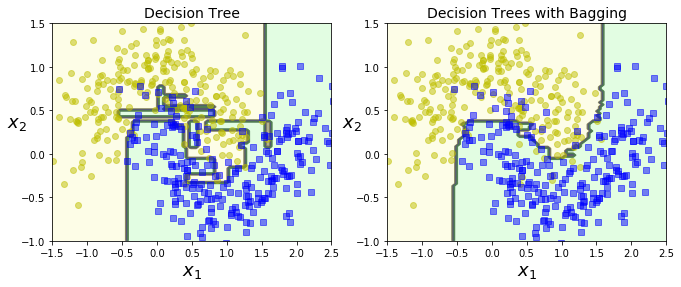

In [5]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

Bootstrap在每个预测器被训练的子集中引入了更多的分集，所以Bagging结束时的偏差比Pasting更高，但这也意味着预测因子最终变得不相关，从而减少了集合的方差。总体而言，Bagging通常会导致更好的模型，这就解释了为什么它通常是首选的。然而，如果你有空闲时间和CPU功率，可以使用交叉验证来评估Bagging和Pasting哪一个更好。

### 7.2.2 Out-of-Bag 评价
对于Bagging来说，一些实例可能被一些分类器重复采样，但其他的有可能不会被采样。`BaggingClassifier`默认是有放回的采样$m$个实例(`bootstrap=True`)，其中$m$是训练集的大小，这意味着平均下来只有63%的训练实例被每个分类器采样(注：1-e^{-1}=63%)，剩下的37%个没有被采样的训练实例就叫做`Out-of-Bag实例`(即oob实例)。注意对于每一个的分类器它们的37%不是相同的。

因为在训练中分类器从来没有看到过oob实例，所以它可以在这些实例上进行评估，而不需要单独的验证集或交叉验证。你可以拿出每一个分类器的oob来评估集成本身。

在Scikit-Learn中，你可以设置`oob_score=True`，模型在训练后会创建一个`BaggingClassifier`实例来自动评估得分。接下来的代码展示了这个操作。评估结果通过变量`oob_score_`来显示：

In [6]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
    

In [7]:
bag_clf.oob_score_

0.8986666666666666

根据这个oob评估，`BaggingClassifier`可以再测试集上达到89.9%的准确率。让我们验证一下：

In [8]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

我们在测试集上得到了93.6%的准确率，足够接近了！

对于每个训练实例oob决策函数也可通过`oob_decision_function_`变量来展示。在这种情况下(当基决策器有`predict_proba()`时)，决策函数会对每个训练实例返回类别概率。例如，oob评估预测第二个训练实例有60.6%的概率属于正类(39.4%属于负类)：

In [9]:
bag_clf.oob_decision_function_[0:2]

array([[0.37016575, 0.62983425],
       [0.3880597 , 0.6119403 ]])

## 7.3 随机贴片与随机子空间
BaggingClassifier也支持特征采样，特征采样由两个超参数`max_features`和`bootstrap_features`控制。它们的工作方式与`max_samples`和`bootstrap`是一样，但这是对于特征采样而不是实例采样。因此，每一个分类器都会被在随机的输入特征内进行训练。

当你在处理高维度输入下(例如图片)此方法尤其有效。同时对训练实例和特征的采样被叫做**随机贴片**。保留了所有的训练实例(例如`bootstrap=False`和`max_samples=1.0`)，但是对特征采样(`bootstrap_features=True`并且/或者`max_features`小于1.0)叫做**随机子空间**。

采样特征导致预测器更好的多样性，用高偏差换低方差。

## 7.4 随机森林
正如我们所讨论的，随机森林是决策树的一种集成，通常是通过bagging方法(有时是pasting方法)进行训练，并且将`max_samples`设置为训练集的大小。与建立一个`BaggingClassifier`然后放入一个`DecisionTreeClassifier`决策权不同，你可以使用`RandomForestClassifier`(对于回归是`RandomForestRegressor`)。`RandomForestClassifier`更直接、并且作了更好的优化。接下来的代码训练了带有500个树(每个被限制为16叶子结点)的决策森林，使用所有空闲的CPU核：

In [10]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1) 
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [11]:
y_pred_rf = rnd_clf.predict(X_test)

除了一些例外，`RandomForestClassifier`使用`DecisionTreeClassifier`的所有超参数(决定树怎么生长)，以及`BaggingClassifier`的超参数，这些参数一起控制集成方法本身。

随机森林算法在树生长时引入了额外的随机；与在节点分裂时需要找到最好分裂特征相反(详见第六章)，它在一个随机的特征集中寻找最好的特征。它导致了树的差异性，并且再一次用高偏差换低方差，总的来说是一个更好的模型。以下是`BaggingClassifier`大致相当于之前的`RandomForestClassifier`：

In [12]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="random", max_leaf_nodes=16), 
                            n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)
bag_clf

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=16,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='random'),
    

### 7.4.1 极端随机树
当你在随机森林上生长树时，在每个结点分裂时只考虑随机特征集上的特征(正如之前讨论过的一样)。相比于找到更好的特征我们可以通过使用对特征使用随机阈值使树更加随机(像规则决策树一样)。

这种极端随机的树被简称为`Extremely Randomized Trees`(极端随机树)，或者更简单的称为`Extra-Tree`，再一次用高偏差换低方差。它还使得`Extra-Tree`比规则的随机森林更快地训练，因为在每个节点上找到每个特征的最佳阈值是生长树最耗时的任务之一。

你可以使用Scikit-Learn的`ExtraTreesClassifier`来创建一个`Extra-Tree`分类器，它的API跟`RandomForestClassifier`是相同的。类似的，`ExtraTreesRegressor`与`RandomForestRegressor`的API也是相同。

> 我们很难去分辨`ExtraTreesClassifier`和`RandomForestClassifier`到底哪个更好。通常情况下是通过交叉验证来比较它们(使用网格搜索调整超参数)。

### 7.4.2 特征重要度
最后，如果你观察一个单一决策树，重要的特征会出现在更靠近根部的位置，而不重要的特征会经常出现在靠近叶子的位置。因此我们可以通过计算一个特征在森林的全部树中出现的平均深度来预测特征的重要性。Scikit-Learn在训练后会自动计算每个特征的重要度。你可以通过`feature_importances_`变量来查看结果。例如如下代码在iris数据集(第四章介绍)上训练了一个`RandomForestClassifier`模型，然后输出了每个特征的重要性。看来，最重要的特征是花瓣长度(44%)和宽度(42%)，而萼片长度和宽度相对比较是不重要的(分别为11%和2%)：

In [13]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09945045536667829
sepal width (cm) 0.024055431213114004
petal length (cm) 0.4340221412740777
petal width (cm) 0.44247197214613004


相似的，如果你在MNIST数据及上训练随机森林分类器(在第三章介绍)，然后画出每个像素的重要性，你可以得到`图7-6`的图片。

<img src="images/07_06.png" style="width:500px;"/>

随机森林可以非常方便快速得了解哪些特征实际上是重要的，特别是你需要进行特征选择的时候。

## 7.5 提升
`提升`(Boosting，最初称为`假设增强`)指的是可以将几个弱学习者组合成强学习者的集成方法。对于大多数的提升方法的思想就是按顺序去训练分类器，每一个都要尝试修正前面的分类器的错误。现如今已经有很多的提升方法了，但最著名的就是`AdaBoost`(适应性提升，是`Adaptive Boosting`的简称)和`Gradient Boosting`(梯度提升)。让我们先从`AdaBoost`说起。

### 7.5.1 AdaBoost
使一个新的分类器去修正之前分类结果的方法就是对之前分类结果不对的训练实例多加关注。这导致新的预测因子越来越多地聚焦于这种情况。这是AdaBoost使用的技术。

举个例子，构建一个AdaBoost分类器，第一个基分类器(例如一个决策树)被训练后在训练集上做预测，在误分类训练实例上的权重就增加了。第二个分类机使用更新过的权重然后再一次训练，权重更新，以此类推(详见`图7-7`)。

<img src="images/07_07.png" style="width:500px;"/>

`图7-8`显示连续五次预测的moons数据集的决策边界(在本例中，每一个分类器都是高度正则化带有RBF核的SVM)。第一个分类器误分类了很多实例，所以它们的权重被提升了。第二个分类器因此对这些误分类的实例分类效果更好，以此类推。右边的图代表了除了学习率减半外(误分类实例权重每次迭代上升一半)相同的预测序列。你可以看出，序列学习技术与梯度下降很相似，除了调整单个预测因子的参数以及最小化代价函数之外，AdaBoost增加了集合的预测器，逐渐使其更好。

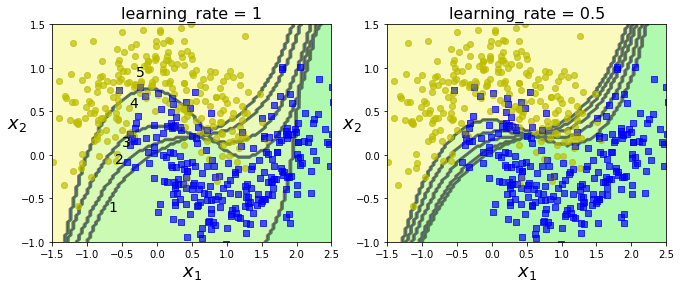

In [14]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

一旦所有的分类器都被训练后，除了分类器根据整个训练集上的准确率被赋予的权重外，集成预测就非常像`Bagging`和`Pasting`了。

> 序列学习技术的一个重要的缺点就是：它不能被并行化(只能按步骤)，因为每个分类器只能在之前的分类器已经被训练和评价后再进行训练。因此，它不像Bagging和Pasting一样可以并行扩展。

让我们详细看一下AdaBoost算法。每一个实例的权重$w^{(i)}$初始都被设为$\frac{1}{m}$。第一个分类器被训练，然后他的权重误差率$r_1$在训练集上算出，详见`公式7-1`。

- $\displaystyle \sum_{i=1}^{m}w^{(i)}, \quad r_j=\frac{\hat{y}_j^{(i)}\ne y^{(i)}}{\sum_{i=1}^{m}w^{(i)}}$

其中，$\hat{y}_j^{(i)}$是第$j$个分类器对于第$i$实例的预测。

分类器的权重$\alpha_{j}$随后用`公式7-2`计算出来。其中$\eta$是超参数学习率(默认为1)。分类器准确率越高，它的权重就越高。如果它只是瞎猜，那么它的权重会趋近于0。然而，如果它总是出错(比瞎猜的几率都低)，它的权重会是负数。

- $\displaystyle \alpha_j = \eta \log\frac{1-r_j}{r_j}$

接下来实例的权重会按照`公式7-3`更新：误分类的实例权重会被提升。

- $for \quad i = 1,2,...,m$
- $\displaystyle\begin{equation} w^{(i)} \gets \left\{\begin{array}{l} w^{(i)} & \mathrm{if} \; \hat{y}_j^{(i)}=y^{(i)} \\ w^{(i)}\exp{(\alpha_j)} & \mathrm{if} \; \hat{y}_j^{(i)} \ne y^{(i)} \end{array}\right.\end{equation}$

随后所有实例的权重都被归一化(例如被$\displaystyle\sum_{i=1}^{m}w^{i}$整除)。

最后，一个新的分类器通过更新过的权重训练，整个过程被重复(新的分类器权重被计算，实例的权重被更新，随后另一个分类器被训练，以此类推)。当规定的分类器数量达到或者最好的分类器被找到后算法就会停止。

为了进行预测，AdaBoost通过分类器权重$\alpha_{j}$简单的计算了所有的分类器和权重。预测类别会是权重投票中主要的类别。(详见`公式7-4`)

- $\displaystyle\hat{y}(x) = \mathop{\arg\min}_{k} \sum_{j=1, \hat{y}_j(x)}^{N}\alpha_j$

其中$N$是分类器的数量。

Scikit-Learn通常使用AdaBoost的多分类版本`SAMME`(即`Stagewise Additive Modeling using a Multiclass Exponential loss function`，分段加建模使用多类指数损失函数)。如果只有两类别，那么`SAMME`是与AdaBoost相同的。如果分类器可以预测类别概率(例如如果它们有`predict_proba()`)，那么Scikit-Learn使用`SAMME`的变体`SAMME.R`(**R**代表**REAL**)，这种依赖于类别概率分类器通常更好。

接下来的代码训练了一个Adaboost 分类器。分类器使用Scikit-Learn的`AdaBoostClassifier`，并且基于200个`决策树桩` (正如你说期待的，对于回归有`AdaBoostRegressor`)。一个决策树桩是`max_depth=1`的决策树，换句话说，是一个单一的决策节点加上两个叶子结点。这就是`AdaBoostClassifier`的默认基分类器：

In [15]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5) 
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

> 如果你的AdaBoost集成过拟合了训练集，你可以尝试减少基分类器的数量或者对基分类器使用更强的正则化。

### 7.5.2 梯度提升
另一个非常著名的提升算法是梯度提升。与AdaBoost一样，梯度提升也是通过向集成中逐步增加分类器运行的，每一个分类器都修正之前的分类结果。然而，它并不像AdaBoost那样每一次迭代都更改实例的权重，而是使用新的分类器去拟合前面分类器预测的残差。

让我们通过一个使用决策树当做基分类器的简单的回归例子(梯度提升当然也可以用于回归)。这被叫做`梯度提升回归树`(GBRT，Gradient Tree Boosting或者 Gradient Boosted Regression Trees)。首先我们用`DecisionTreeRegressor`去拟合训练集(例如一个有噪二次训练集)：

In [16]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [17]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

现在在第一个分类器的残差上训练第二个分类器：

In [18]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

随后在第二个分类器的残差上训练第三个分类器：

In [19]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

现在我们有了一个包含三个回归器的集成。它可以通过集成所有树的预测来在一个新的实例上进行预测。

In [20]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

`图7-9`在左栏展示了这三个树的预测，在右栏展示了集成的预测。在第一行，集成只有一个树，所以它与第一个树的预测相似。在第二行，一个新的树在第一个树的残差上进行训练。在右边栏可以看出集成的预测等于前两个树预测的和。相同的，在第三行另一个树在第二个数的残差上训练。你可以看到集成的预测会变的更好。

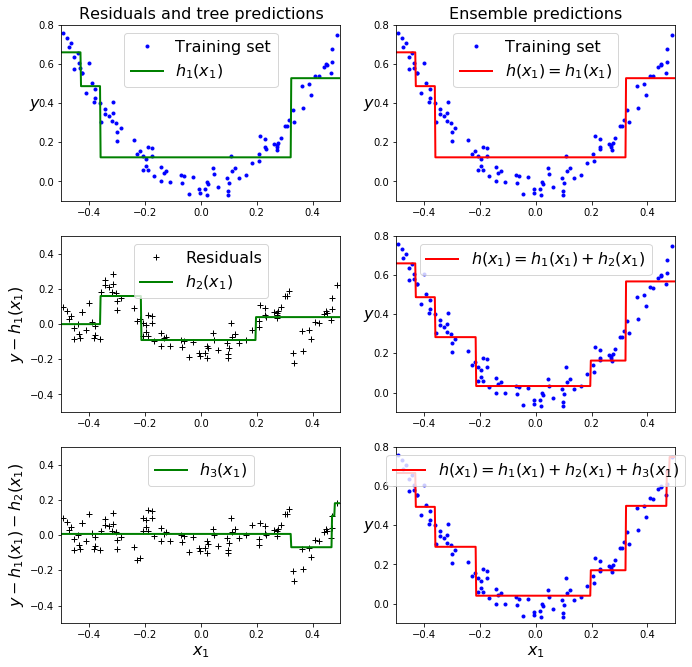

In [21]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

我们可以使用Scikit-Learn中的`GradientBoostingRegressor`来训练GBRT集成。与`RandomForestClassifier`相似，它也有超参数去控制决策树的生长(例如`max_depth`，`min_samples_leaf`等等)，也有超参数去控制集成训练，例如基分类器的数量(`n_estimators`)。接下来的代码创建了与之前相同的集成：

In [22]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

超参数`learning_rate`确立了每个树的贡献。如果你把它设置为一个很小的树，例如0.1，在集成中就需要更多的树去拟合训练集，但预测通常会更好。这个正则化技术叫做`shrinkage`。`图7-10`展示了两个在低学习率上训练的GBRT集成：其中左面是一个没有足够树去拟合训练集的树，右面是有过多的树过拟合训练集的树。

In [23]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

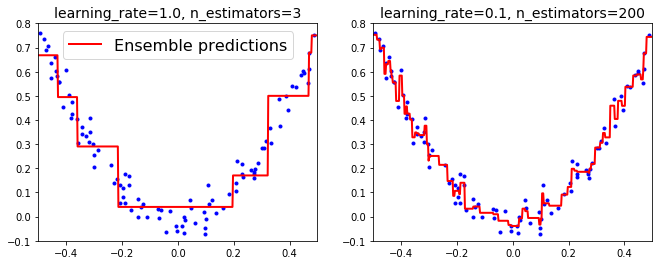

In [24]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

为了找到树的最优数量，你可以使用`早停技术`(early stopping，第四章讨论)。最简单使用这个技术的方法就是使用`staged_predict()`：它在训练的每个阶段(用一棵树、两棵树等）返回一个迭代器。加下来的代码用120个树训练了一个GBRT集成，然后在训练的每个阶段验证错误以找到树的最佳数量，最后使用GBRT树的最优数量训练另一个集成：

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

验证错误在`图7-11`的左面展示，最优模型预测被展示在右面。

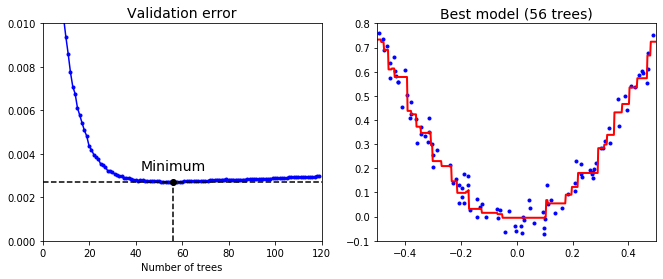

In [26]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.show()

你也可以早早的停止训练来实现早停(与先在一大堆树中训练，然后再回头去找最优数目相反)。你可以通过设置`warm_start=True`来实现 ，这使得当`fit()`方法被调用时ScikitLearn保留现有树，并允许增量训练。接下来的代码在当一行中的五次迭代验证错误没有改善时会停止训练：

In [27]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [28]:
gbrt.n_estimators

61

In [29]:
("Minimum validation MSE:", min_val_error)

('Minimum validation MSE:', 0.002712853325235463)

`GradientBoostingRegressor`也支持指定用于训练每棵树的训练实例比例的超参数`subsample`。例如如果`subsample=0.25`，那么每个树都会在25%随机选择的训练实例上训练。你现在也能猜出来，这也是个高偏差换低方差的作用。它同样也加速了训练。这个技术叫做`随机梯度提升`。

> 也可能对其他损失函数使用梯度提升。这是由损失超参数控制(见Scikit-Learn文档)

It is worth noting that an optimized implementation of Gradient Boosting is available in the popular python library `XGBoost`, which stands for Extreme Gradient Boosting. This package was initially developed by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community (DMLC), and it aims at being extremely fast, scalable and portable. In fact, XGBoost is often an important component of the winning entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

```python
import xgboost

xgb_reg = xgboost.XGBRegressor() 
xgb_reg.fit(X_train, y_train) 
y_pred = xgb_reg.predict(X_val)
```

XGBoost also offers several nice features, such as automatically taking care of early stopping:

```python
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2) 
y_pred = xgb_reg.predict(X_val)
```

You should definitely check it out!

## 7.6 Stacking
本章讨论的最后一个集成方法叫做`Stacking`(stacked generalization的缩写)。这个算法基于一个简单的想法：不使用琐碎(trivial)的函数(如硬投票)来聚合集合中所有分类器的预测，我们为什么不训练一个模型来执行这个聚合？`图7-12`展示了这样一个在新的回归实例上预测的集成。底部三个分类器每一个都有不同的值(3.1、2.7和2.9)，然后最后一个分类器(叫做`blender`或者`meta learner` )把这三个分类器的结果当做输入然后做出最终决策(3.0)。

<img src="images/07_12.png" style="width:500px;"/>

为了训练这个blender ，一个通用的方法是采用留出集。让我们看看它怎么工作。首先，训练集被分为两个子集，第一个子集被用作训练第一层(详见`图7-13`)。

<img src="images/07_13.png" style="width:500px;"/>

接下来，第一层的分类器被用来预测第二个子集(留出集)(详见`7-14`)。这确保了预测结果很“干净”，因为这些分类器在训练的时候没有使用过这些事例。现在对在保持集中的每一个实例都有三个预测值。我们现在可以使用这些预测结果作为输入特征来创建一个新的训练集(这使得这个训练集是三维的)，并且保持目标数值不变。随后blender在这个新的训练集上训练，因此，它学会了预测第一层预测的目标值。

<img src="images/07_14.png" style="width:500px;"/>

显然我们可以用这种方法训练不同的blender (例如一个线性回归，另一个是随机森林等等)：我们得到了一层blender。诀窍是将训练集分成三个子集：第一个子集用来训练第一层，第二个子集用来创建训练第二层的训练集(使用第一层分类器的预测值)，第三个子集被用来创建训练第三层的训练集(使用第二层分类器的预测值)。以上步骤做完了，我们可以通过逐个遍历每个层来预测一个新的实例。详见`图7-15`。

<img src="images/07_15.png" style="width:500px;"/>

然而不幸的是，Scikit-Learn并不直接支持stacking ，但是你自己组建是很容易的(看接下来的练习)。或者你也可以使用开源的项目例如[brew]( https://github.com/viisar/brew)。